In [1]:
from nptdms import TdmsFile
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import datetime


path = r"D:\ML algoritme tl anfaldsdetektion vha HRV\ePatch data from Aarhus to Lausanne\Patients ePatch data\Patient 5\recording 1\Patient 5_1.tdms"
# path = r"D:\ML algoritme tl anfaldsdetektion vha HRV\ePatch data from Aarhus to Lausanne\Patients ePatch data\Patient 6\recording 1\Patient 6_1.tdms"


In [2]:
tdms_file = TdmsFile.read(path)
print(tdms_file.properties)
channel1 = tdms_file.groups()[0]
# select EKG channel if present, otherwise take the first channel in the group
channels = channel1.channels()
ecg_channel = next((ch for ch in channels if ch.name.lower() == 'ekg'), channels[0])

# load raw ECG samples as a float numpy array
ecg_raw = ecg_channel.data.astype(float)

# read common waveform properties with safe fallbacks
wf_start = ecg_channel.properties.get('wf_start_time', ecg_channel.properties.get('wf_start', None))
wf_increment = float(ecg_channel.properties.get('wf_increment', ecg_channel.properties.get('wf_val', 0.0)))
wf_samples = int(ecg_channel.properties.get('wf_samples', ecg_raw.shape[0]))

print(f"Channel: {ecg_channel.name}, samples={ecg_raw.shape[0]}, wf_start={wf_start}, wf_increment={wf_increment}")


OrderedDict([('name', 'Thue Bundgaard 12_10_2016 kl_110502__14_10_2016_ kl_080000.tdms'), ('author', 'Jesper'), ('description', ''), ('registertxt1', 'Written by National Instruments LabVIEW')])
Channel: EKG, samples=82460288, wf_start=2016-10-12T09:05:02.000000, wf_increment=0.001953125


In [3]:
# # time axis in seconds relative to wf_start
# time_seconds = np.arange(ecg_raw.shape[0]) * wf_increment

# # absolute datetimes for each sample if wf_start is convertible
# try:
#     start_dt = pd.to_datetime(wf_start).to_pydatetime()
#     time_datetimes = [start_dt + datetime.timedelta(seconds=float(s)) for s in time_seconds]
# except Exception:
#     time_datetimes = None


In [4]:
# Print all groups and channels in the TDMS file
for group in tdms_file.groups():
    print(f"Group: {group.name}")
    for channel in group.channels():
        print(f"  Channel: {channel.name}")
        for prop_name, prop_value in channel.properties.items():
            print(f"    Property: {prop_name} = {prop_value}")

Group: Untitled
  Channel: EKG
    Property: wf_start_time = 2016-10-12T09:05:02.000000
    Property: wf_start_offset = 0.0
    Property: wf_increment = 0.001953125
    Property: wf_samples = 82460288
    Property: DigitalMaximum = 32767
    Property: DigitalMinimum = -32768
    Property: NI_ChannelName = EKG
    Property: NI_ExpIsRelativeTime = False
    Property: wf_time_pref = absolute
    Property: NI_ExpStartTimeStamp = 2016-10-12T09:05:02.000000
    Property: NI_ExpTimeStamp = 2016-10-12T09:05:02.000000
    Property: NI_ExpXDimension = t
    Property: wf_xname = Time
    Property: wf_xunit_string = s
    Property: NI_UnitDescription = uV
    Property: unit_string = uV
    Property: PhysicalMaximum = 90298.0
    Property: PhysicalMinimum = -90298.0
    Property: PreFilter = 
    Property: TransducerType = 
    Property: ValsPerRec = 128


In [5]:

time1 = [datetime.datetime(2016, 10, 13, 7, 26, 57), datetime.datetime(2016, 10, 13, 7, 26, 31), datetime.datetime(2016, 10, 13, 7, 28, 57), datetime.datetime(2016, 10, 13, 7, 26, 58)]
time2 = [datetime.datetime(2016, 10, 13, 14, 47, 50), datetime.datetime(2016, 10, 13, 14, 47, 29), datetime.datetime(2016, 10, 13, 14, 49, 23), datetime.datetime(2016, 10, 13, 14, 49, 24)]
time3 = [datetime.datetime(2016, 10, 13, 15, 36, 28), datetime.datetime(2016, 10, 13, 15, 36, 30), datetime.datetime(2016, 10, 13, 15, 38, 38), datetime.datetime(2016, 10, 13, 15, 38, 38)]

# time1 = [datetime.datetime(2017, 1, 24, 20, 42, 18), datetime.datetime(2017, 1, 24, 20, 42, 14), datetime.datetime(2017, 1, 24, 20, 44, 22), datetime.datetime(2017, 1, 24, 20, 44, 25)]

# Seizure_times = [time1, time2, time3]

In [6]:
# print(Seizure_times)

In [7]:
import arrow

timestamp = channel.properties['wf_start_time']
local_time = arrow.get(timestamp.astype(datetime.datetime)).to('local')
print(local_time.format())

2016-10-12 11:05:02+02:00


In [8]:
local_time

<Arrow [2016-10-12T11:05:02+02:00]>

In [9]:
local_time.datetime

datetime.datetime(2016, 10, 12, 11, 5, 2, tzinfo=tzlocal())

In [10]:
# Flip the calculation: time1 - timestamp

# convert numpy.datetime64 timestamp to Python datetime (overwrites ts_dt if present)
ts_dt = pd.to_datetime(timestamp).to_pydatetime()

# Differences: each datetime in time1 minus the timestamp
diffs_time1_timestamp = [dt - ts_dt for dt in time1]

# Make time1 datetimes timezone-aware in the same timezone as local_time (overwrite if needed)
seizure_time1_arrows = [arrow.get(dt).replace(tzinfo=local_time.tzinfo) for dt in time1]

# Differences: each time1 (as Arrow) minus local_time
diffs_time1_local_time = [s - local_time for s in seizure_time1_arrows]

# Display results
print("timestamp (converted) ->", ts_dt)
print("Differences (time1 - timestamp):")
for i, d in enumerate(diffs_time1_timestamp, 1):
    print(f"  {i}: {d}")

print("\nlocal_time ->", local_time)
print("Differences (time1 treated in same timezone - local_time):")
for i, d in enumerate(diffs_time1_local_time, 1):
    print(f"  {i}: {d}")

timestamp (converted) -> 2016-10-12 09:05:02
Differences (time1 - timestamp):
  1: 22:21:55
  2: 22:21:29
  3: 22:23:55
  4: 22:21:56

local_time -> 2016-10-12T11:05:02+02:00
Differences (time1 treated in same timezone - local_time):
  1: 20:21:55
  2: 20:21:29
  3: 20:23:55
  4: 20:21:56


41223680.0
41285120.0
37537280.0
37598720.0


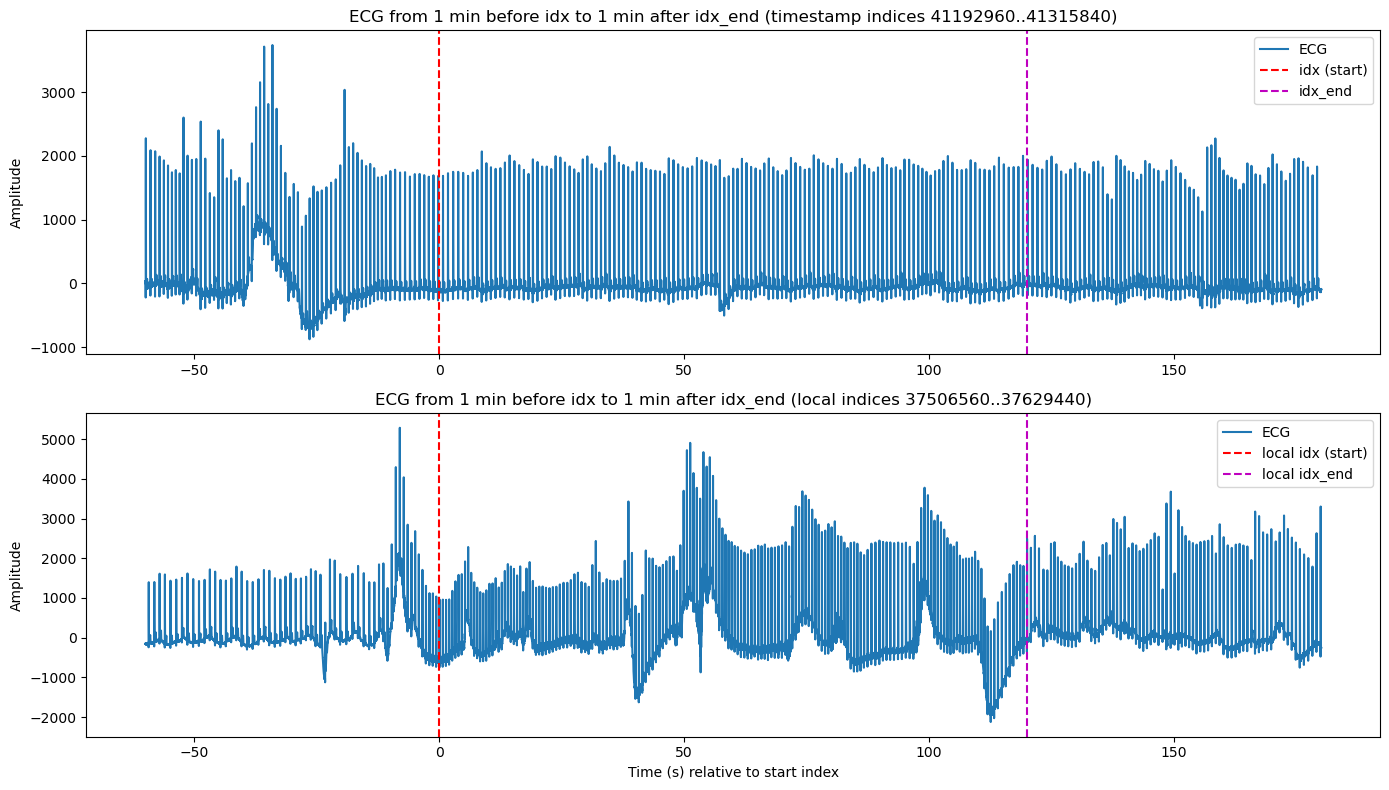

In [11]:
wf_increment = channel.properties['wf_increment']
num_samples = channel.properties['wf_samples']

timestamp_window_idx = diffs_time1_timestamp[0].total_seconds() / wf_increment
print(timestamp_window_idx)
timestamp_window_idx_end = diffs_time1_timestamp[2].total_seconds() / wf_increment
print(timestamp_window_idx_end)
local_time_window_idx = diffs_time1_local_time[0].total_seconds() / wf_increment
print(local_time_window_idx)
local_time_window_idx_end = diffs_time1_local_time[2].total_seconds() / wf_increment
print(local_time_window_idx_end)

# show data from 1 minute before idx to 1 minute after idx_end for both timestamp and local_time spans
pad_seconds = 60
pad_samples = int(round(pad_seconds / wf_increment))

# timestamp-based span
ts_idx = int(round(timestamp_window_idx))
ts_idx_end = int(round(timestamp_window_idx_end))
ts_plot_start = max(0, ts_idx - pad_samples)
ts_plot_end = min(ecg_raw.shape[0], ts_idx_end + pad_samples)
ts_plot_seg = ecg_raw[ts_plot_start:ts_plot_end]
t_ts_plot = (np.arange(ts_plot_start, ts_plot_end) - ts_idx) * wf_increment  # seconds relative to first idx

# local_time-based span
lt_idx = int(round(local_time_window_idx))
lt_idx_end = int(round(local_time_window_idx_end))
lt_plot_start = max(0, lt_idx - pad_samples)
lt_plot_end = min(ecg_raw.shape[0], lt_idx_end + pad_samples)
lt_plot_seg = ecg_raw[lt_plot_start:lt_plot_end]
t_lt_plot = (np.arange(lt_plot_start, lt_plot_end) - lt_idx) * wf_increment  # seconds relative to local idx

plt.figure(figsize=(14, 8))

ax1 = plt.subplot(2, 1, 1)
ax1.plot(t_ts_plot, ts_plot_seg, label='ECG')
# vertical lines at idx (0) and idx_end
ax1.axvline(0, color='r', linestyle='--', label='idx (start)')
ax1.axvline((ts_idx_end - ts_idx) * wf_increment, color='m', linestyle='--', label='idx_end')
ax1.set_title(f'ECG from 1 min before idx to 1 min after idx_end (timestamp indices {ts_plot_start}..{ts_plot_end})')
ax1.set_ylabel('Amplitude')
ax1.legend()

ax2 = plt.subplot(2, 1, 2, sharex=None)
ax2.plot(t_lt_plot, lt_plot_seg, label='ECG')
ax2.axvline(0, color='r', linestyle='--', label='local idx (start)')
ax2.axvline((lt_idx_end - lt_idx) * wf_increment, color='m', linestyle='--', label='local idx_end')
ax2.set_title(f'ECG from 1 min before idx to 1 min after idx_end (local indices {lt_plot_start}..{lt_plot_end})')
ax2.set_xlabel('Time (s) relative to start index')
ax2.set_ylabel('Amplitude')
ax2.legend()

plt.tight_layout()
plt.show()

In [12]:
import os
# Load through all patient folders
path_patients_folder = r"D:\ML algoritme tl anfaldsdetektion vha HRV\ePatch data from Aarhus to Lausanne\Patients ePatch data"
for patient_folder in os.listdir(path_patients_folder):
    patient_path = os.path.join(path_patients_folder, patient_folder)
    if os.path.isdir(patient_path):
        print(f"Processing patient folder: {patient_folder}")
        for recording_folder in os.listdir(patient_path):
            recording_path = os.path.join(patient_path, recording_folder)
            if os.path.isdir(recording_path):
                print(f"  Processing recording folder: {recording_folder}")
                # if folder name contains 'enrollment' (case-insensitive) search one level deeper
                if 'enrollment' in recording_folder.lower() or 'enrollment' in recording_path.lower():
                    for subfolder in os.listdir(recording_path):
                        sub_path = os.path.join(recording_path, subfolder)
                        if os.path.isdir(sub_path):
                            print(f"    Entering enrollment subfolder: {subfolder}")
                            for file_name in os.listdir(sub_path):
                                if file_name.endswith('.tdms'):
                                    file_path = os.path.join(sub_path, file_name)
                                    print(f"      Found TDMS file: {file_name}")
                                    patient_number = file_name.split('_')
                                    print(f"      Patient number extracted: {patient_number[0]}")
                                    # Here you can add code to process each TDMS file as needed
                else:
                    for file_name in os.listdir(recording_path):
                        if file_name.endswith('.tdms'):
                            file_path = os.path.join(recording_path, file_name)
                            print(f"    Found TDMS file: {file_name}")
                            patient_number = file_name.split('_')
                            print(f"    Patient number extracted: {patient_number[0]}")
                            # Here you can add code to process each TDMS file as needed

Processing patient folder: Patient 1
  Processing recording folder: recording 1
    Found TDMS file: Patient 1_1.tdms
    Patient number extracted: Patient 1
  Processing recording folder: recording 2
    Found TDMS file: Patient 1_2.tdms
    Patient number extracted: Patient 1
Processing patient folder: Patient 10
  Processing recording folder: recording 1
    Found TDMS file: Patient 10_1.tdms
    Patient number extracted: Patient 10
Processing patient folder: Patient 11
  Processing recording folder: recording 1
    Found TDMS file: Patient 11_1.tdms
    Patient number extracted: Patient 11
  Processing recording folder: recording 2
    Found TDMS file: Patient 11_2.tdms
    Patient number extracted: Patient 11
Processing patient folder: Patient 12
  Processing recording folder: recording 1
    Found TDMS file: Patient 12_1.tdms
    Patient number extracted: Patient 12
  Processing recording folder: recording 2
    Found TDMS file: Patient 12_2.tdms
    Patient number extracted: Pat

In [13]:
path_seizure_folder = r"D:\ML algoritme tl anfaldsdetektion vha HRV\ePatch data from Aarhus to Lausanne\Seizure log ePatch patients with seizures"



In [15]:
# from ecg_quality.ECGQualityChecker import ECGQualityChecker  

# checker = ECGQualityChecker()
 
# signal = ...	 

# output = checker.process_signal(signal)  

In [16]:
import neurokit2 as nk
ecg_clean = nk.ecg_clean(ecg_raw, sampling_rate=512)

SUMMARY:
Samples compared: 82460288, Sampling rate: 512 Hz
Raw stats: {'min': -90298.0, 'max': 90298.0, 'mean': -1.490538971533526, 'median': -45.46935225451982, 'std': 669.872115567426, 'rms': 669.8737738717684}
Clean stats: {'min': -96238.36804600258, 'max': 96210.71445554294, 'mean': 1.710725212831344e-05, 'median': -48.90918231590812, 'std': 443.774550208032, 'rms': 443.77455020803257}
Noise stats: {'min': -102182.52930817229, 'max': 102811.98795993502, 'mean': -1.4905560787856522, 'median': -4.016669579758322, 'std': 466.4533259157917, 'rms': 466.4557074528376}
MAE: 114.3181, RMSE: 466.4557, Corr: 0.7200, SNR: -0.43 dB


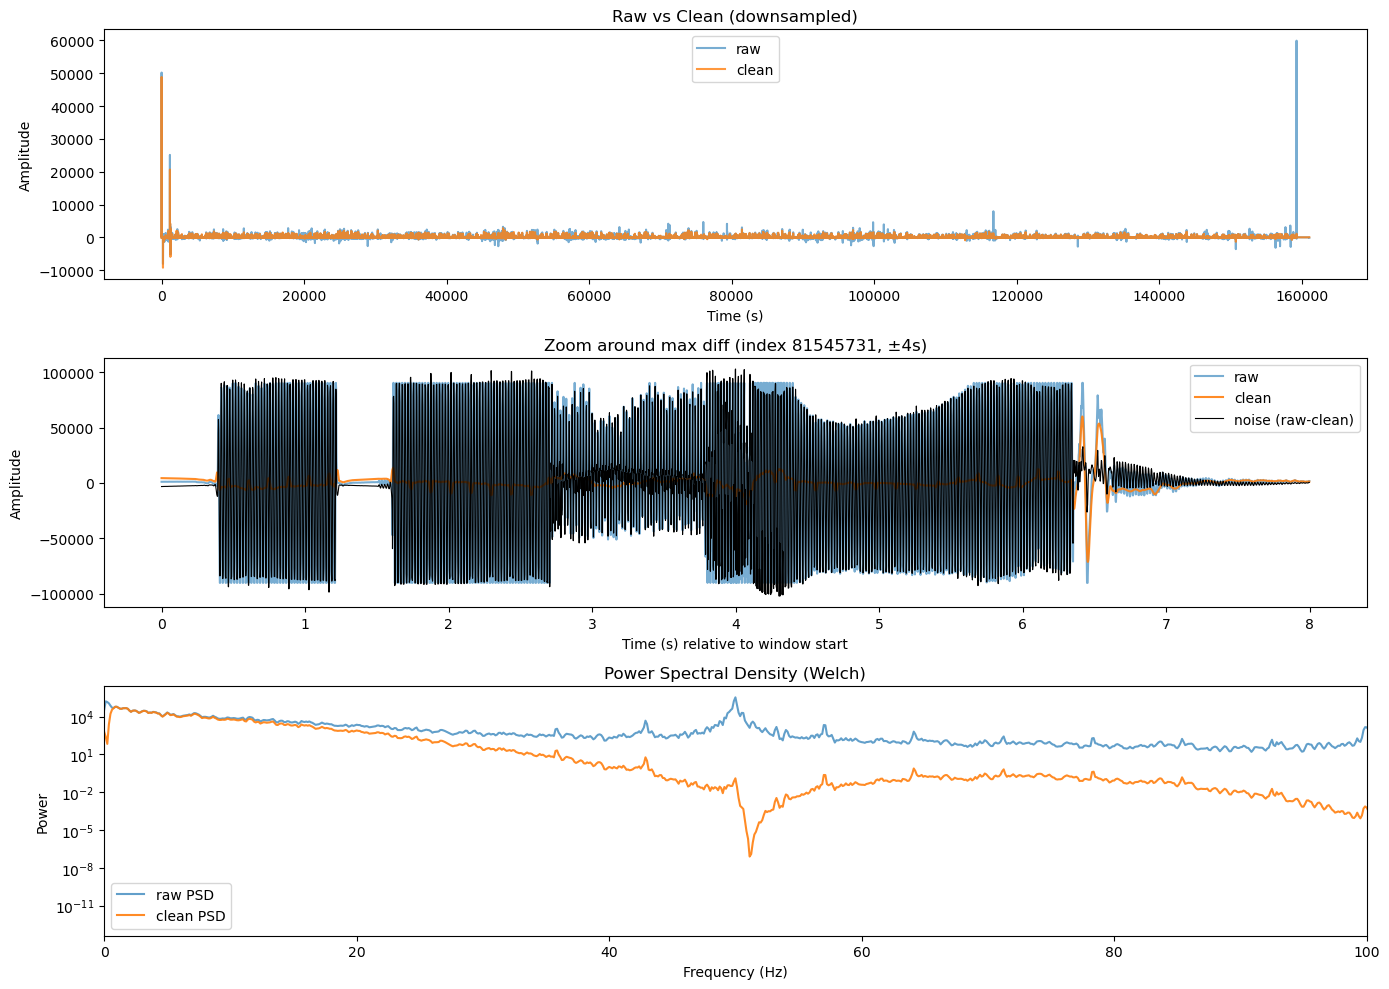

In [17]:
from scipy.signal import welch

# Compare clean and raw ECG signals: statistics, SNR, correlation, PSD and plots.
# Uses existing notebook variables: ecg_raw, ecg_clean, wf_increment, plt, np

# trim to common length
n = min(ecg_raw.shape[0], ecg_clean.shape[0])
raw = ecg_raw[:n].astype(float)
clean = ecg_clean[:n].astype(float)
noise = raw - clean

# sampling
sr = int(round(1.0 / wf_increment)) if wf_increment != 0 else 1
t = np.arange(n) / sr

# basic statistics
def stats(x):
    return {
        "min": float(np.min(x)),
        "max": float(np.max(x)),
        "mean": float(np.mean(x)),
        "median": float(np.median(x)),
        "std": float(np.std(x)),
        "rms": float(np.sqrt(np.mean(x ** 2))),
    }

stats_raw = stats(raw)
stats_clean = stats(clean)
stats_noise = stats(noise)

# error / similarity metrics
mae = float(np.mean(np.abs(noise)))
mse = float(np.mean(noise ** 2))
rmse = float(np.sqrt(mse))
corr = float(np.corrcoef(raw, clean)[0, 1])

# SNR (dB) using clean as signal
p_signal = np.mean(clean ** 2)
p_noise = np.mean(noise ** 2) if np.any(noise) else 1e-12
snr_db = 10.0 * np.log10(p_signal / p_noise)

# PSD (Welch)

nperseg = 4096
f_raw, P_raw = welch(raw, fs=sr, nperseg=nperseg)
f_clean, P_clean = welch(clean, fs=sr, nperseg=nperseg)

# print summary
print("SUMMARY:")
print(f"Samples compared: {n}, Sampling rate: {sr} Hz")
print("Raw stats:", stats_raw)
print("Clean stats:", stats_clean)
print("Noise stats:", stats_noise)
print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}, Corr: {corr:.4f}, SNR: {snr_db:.2f} dB")

# plotting (downsample for full-length plotting)
max_points = 20000
step = max(1, n // max_points)
idx_ds = np.arange(0, n, step)
t_ds = idx_ds / sr

plt.figure(figsize=(14, 10))

ax1 = plt.subplot(3, 1, 1)
ax1.plot(t_ds, raw[idx_ds], label="raw", alpha=0.6)
ax1.plot(t_ds, clean[idx_ds], label="clean", alpha=0.8)
ax1.set_title("Raw vs Clean (downsampled)")
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Amplitude")
ax1.legend(loc="best")

# zoom around largest discrepancy
idx_max = int(np.argmax(np.abs(noise)))
win_seconds = 4
win_samples = int(win_seconds * sr)
start = max(0, idx_max - win_samples)
end = min(n, idx_max + win_samples)
t_zoom = (np.arange(start, end) - start) / sr

ax2 = plt.subplot(3, 1, 2)
ax2.plot(t_zoom, raw[start:end], label="raw", alpha=0.6)
ax2.plot(t_zoom, clean[start:end], label="clean", alpha=0.9)
ax2.plot(t_zoom, (raw[start:end] - clean[start:end]), label="noise (raw-clean)", color="k", linewidth=0.8)
ax2.set_title(f"Zoom around max diff (index {idx_max}, ±{win_seconds}s)")
ax2.set_xlabel("Time (s) relative to window start")
ax2.set_ylabel("Amplitude")
ax2.legend(loc="best")

# PSD comparison (log scale)
ax3 = plt.subplot(3, 1, 3)
ax3.semilogy(f_raw, P_raw, label="raw PSD", alpha=0.7)
ax3.semilogy(f_clean, P_clean, label="clean PSD", alpha=0.9)
ax3.set_xlim(0, min(100, sr/2))
ax3.set_title("Power Spectral Density (Welch)")
ax3.set_xlabel("Frequency (Hz)")
ax3.set_ylabel("Power")
ax3.legend(loc="best")

plt.tight_layout()
plt.show()

In [25]:
pad_seconds_analysis = 60
pad_samples_analysis = int(round(pad_seconds_analysis / wf_increment))
random_idx = 10000000
ecg_clean_analysis = ecg_clean[random_idx:random_idx+pad_samples_analysis]
print(len(ecg_clean_analysis))
ecg_clean_analysis[1000]

30720


-65.74830987476086

In [32]:
import neurokit2 as nk
import pandas as pd
import numpy as np

ecg = ecg_clean_analysis  # din 1D array (30720 punkter ved 512 Hz)

# 1) Processér først
signals, info = nk.ecg_process(ecg, sampling_rate=512)

# (valgfrit) sanity check: er der overhovedet peaks?
n_peaks = int(np.nansum(signals["ECG_R_Peaks"].values))
print(f"Antal fundne R-peaks: {n_peaks}")

if n_peaks < 3:
    raise ValueError("For få R-peaks fundet i vinduet til at køre ecg_analyze() meningsfuldt.")

# 2) Analyser korrekt
res = nk.ecg_analyze(signals, sampling_rate=512)
print(res)


Antal fundne R-peaks: 57
  ECG_Rate_Mean              HRV_MeanNN               HRV_SDNN HRV_SDANN1  \
0      57.19591  [[1050.3627232142858]]  [[97.14547837861264]]    [[nan]]   

  HRV_SDNNI1 HRV_SDANN2 HRV_SDNNI2 HRV_SDANN5 HRV_SDNNI5  \
0    [[nan]]    [[nan]]    [[nan]]    [[nan]]    [[nan]]   

                HRV_RMSSD  ...              HRV_SampEn             HRV_ShanEn  \
0  [[39.225512138872304]]  ...  [[0.9650808960435872]]  [[5.351823225551766]]   

              HRV_FuzzyEn               HRV_MSEn               HRV_CMSEn  \
0  [[0.8504993039986374]]  [[0.693889572284842]]  [[0.6915115769852246]]   

               HRV_RCMSEn                  HRV_CD                 HRV_HFD  \
0  [[0.6865696999623694]]  [[1.7290202159837014]]  [[1.6762120004946657]]   

                  HRV_KFD                 HRV_LZC  
0  [[1.6047347533192269]]  [[0.5185138323265718]]  

[1 rows x 83 columns]


c:\Users\kvjkv\anaconda3\envs\kvj\Lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


In [ ]:
# Safely run ecg_analyze and fall back to processing first if it raises UnboundLocalError.
# Use existing sampling rate variable `sr` (512) if present.
_sampling_rate = globals().get("sr", 512)

try:
	analysis_res = nk.ecg.ecg_analyze(ecg_clean, sampling_rate=_sampling_rate, method="auto")
except UnboundLocalError:
	# Some neurokit versions may raise UnboundLocalError inside ecg_analyze when peaks aren't found.
	# First try to preprocess the signal, then analyze the processed output.
	try:
		processed = nk.ecg_process(ecg_clean, sampling_rate=_sampling_rate)
		# nk.ecg_process returns (signals, info) in many versions
		if isinstance(processed, tuple) and len(processed) == 2:
			signals, info = processed
		else:
			signals = processed
		analysis_res = nk.ecg.ecg_analyze(signals, sampling_rate=_sampling_rate, method="auto")
	except Exception as e:
		# final fallback: return empty dict and print error for debugging
		print("ecg_analyze failed after preprocessing:", repr(e))
		analysis_res = {}